# Label Shuffle Experiment for Progressive Learning

The progressive learning package utilizes representation ensembling algorithms to sequentially learn a representation for each task and ensemble both old and new representations for all future decisions. 

Here, two complementary representation ensembling algorithms based on decision forests (Lifelong Forest) and deep networks (Lifelong Network) demonstrate forward and backward knowledge transfer of tasks on the CIFAR100 dataset with the labels shuffled. The experiment reproduces the benchmarking adversarial experiment ran in the paper "A General Approach to Progressive Learning" by Vogelstein, et al (2020). https://arxiv.org/pdf/2004.12908.pdf  

### Import necessary packages and modules

In [1]:
import sys
import os
import random
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from joblib import Parallel, delayed
from multiprocessing import Pool
import time
from itertools import product
import pandas as pd
import pickle
from sklearn.model_selection import StratifiedKFold
from math import log2, ceil 
import seaborn as sns
import matplotlib.pyplot as plt

### Import models from proglearn
From forest.py and network.py, we import the necessary models to perform the progressive learning. 

In [2]:
from forest import LifelongClassificationForest 
from network import LifelongClassificationNetwork

### Load CIFAR100 data 
We load the CIFAR100 dataset from Keras, and store it in a variable. The training and test partitions are concatenated into one variable called `data_x`. The data is obtained from https://keras.io/api/datasets/cifar100/ .

The label shuffle experiment randomly permutes the class labels within each task from task 2 to 9, rendering each of these tasks adversarial with regard to the first task. We show through this experiment that both L2F and L2N are invariant to class lable shuffling, and both demonstrate transfer.  

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar100.load_data()
data_x = np.concatenate([X_train, X_test])

### Functions
Below are the functions used for training the model. 

`cross_val_data`: Splits the data into training and test sets

`run_parallel_exp`: Wrapper method for the `LF_experiment` function, also used to configure GPU

`LF_experiment`: Function that declares and trains the model, and performs validation with respect to the test data to compute the accuracy of the model at a particular iteration.  

In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
def cross_val_data(data_x, data_y, num_points_per_task, total_task=10, shift=1):
    x = data_x.copy()
    y = data_y.copy()
    idx = [np.where(data_y == u)[0] for u in np.unique(data_y)]
    
    batch_per_task=5000//num_points_per_task
    sample_per_class = num_points_per_task//total_task

    for task in range(total_task):
        for batch in range(batch_per_task):
            for class_no in range(task*10,(task+1)*10,1):
                indx = np.roll(idx[class_no],(shift-1)*100)
                
                if batch==0 and class_no==0 and task==0:
                    train_x = x[indx[batch*sample_per_class:(batch+1)*sample_per_class]]
                    test_x = x[indx[batch*total_task+num_points_per_task:(batch+1)*total_task+num_points_per_task]]
                    train_y = np.random.randint(low = 0, high = total_task, size = sample_per_class)
                    test_y = np.random.randint(low = 0, high = total_task, size = total_task)
                else:
                    train_x = np.concatenate((train_x, x[indx[batch*sample_per_class:(batch+1)*sample_per_class]]), axis=0)
                    test_x = np.concatenate((test_x, x[indx[batch*total_task+num_points_per_task:(batch+1)*total_task+num_points_per_task]]), axis=0)
                    if task == 0:
                        train_y = np.concatenate((train_y, y[indx[batch*sample_per_class:(batch+1)*sample_per_class]]), axis=0)
                        test_y = np.concatenate((test_y, y[indx[batch*total_task+num_points_per_task:(batch+1)*total_task+num_points_per_task]]), axis=0)
                    else:
                        train_y = np.concatenate((train_y, np.random.randint(low = 0, high = total_task, size = sample_per_class)), axis=0)
                        test_y = np.concatenate((test_y, np.random.randint(low = 0, high = total_task, size = total_task)), axis = 0)
                
    return train_x, train_y, test_x, test_y

In [6]:
def run_parallel_exp(data_x, data_y, n_trees, model, num_points_per_task, slot=0, shift=1):
    train_x, train_y, test_x, test_y = cross_val_data(data_x, data_y, num_points_per_task, shift=shift)
    
    if model == "dnn":
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        sess = tf.Session(config=config)
        with tf.device('/gpu:'+str(shift % 4)):
            LF_experiment(train_x, train_y, test_x, test_y, n_trees, shift, slot, model, num_points_per_task, acorn=12345)
    else:
        LF_experiment(train_x, train_y, test_x, test_y, n_trees, shift, slot, model, num_points_per_task, acorn=12345)

In [17]:
def LF_experiment(train_x, train_y, test_x, test_y, ntrees, shift, slot, model, num_points_per_task, acorn=None):
    
    #We initialize lists to store the results   
    df = pd.DataFrame()
    shifts = []
    tasks = []
    base_tasks = []
    accuracies_across_tasks = []
    train_times_across_tasks = []
    inference_times_across_tasks = []
    learner = None
    
    if model == "dnn":
        # We initialize the neural network model for the DNN
        network = keras.Sequential()
        network.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=np.shape(train_x)[1:]))
        network.add(layers.BatchNormalization())
        network.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides = 2, padding = "same", activation='relu'))
        network.add(layers.BatchNormalization())
        network.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides = 2, padding = "same", activation='relu'))
        network.add(layers.BatchNormalization())
        network.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides = 2, padding = "same", activation='relu'))
        network.add(layers.BatchNormalization())
        network.add(layers.Conv2D(filters=254, kernel_size=(3, 3), strides = 2, padding = "same", activation='relu'))

        network.add(layers.Flatten())
        network.add(layers.BatchNormalization())
        network.add(layers.Dense(2000, activation='relu'))
        network.add(layers.BatchNormalization())
        network.add(layers.Dense(2000, activation='relu'))
        network.add(layers.BatchNormalization())
        network.add(layers.Dense(units=10, activation = 'softmax'))
        
        learner = LifelongClassificationNetwork(network=network)
        
    elif model == "uf":
        learner = LifelongClassificationForest(n_estimators=ntrees)
                                           
    for task_ii in range(10):
        print("Starting Task {} For Fold {} For Slot {}".format(task_ii, shift, slot))
        if acorn is not None:
            np.random.seed(acorn)

        train_start_time = time.time()
    
        if task_ii == 0:
            learner.add_task(
                X = train_x[task_ii*5000+slot*num_points_per_task:task_ii*5000+(slot+1)*num_points_per_task], 
                y = train_y[task_ii*5000+slot*num_points_per_task:task_ii*5000+(slot+1)*num_points_per_task],
                task_id=0
            )
        else:
            learner.add_transformer(
                X = train_x[task_ii*5000+slot*num_points_per_task:task_ii*5000+(slot+1)*num_points_per_task],
                y = train_y[task_ii*5000+slot*num_points_per_task:task_ii*5000+(slot+1)*num_points_per_task]
            )
            
        train_end_time = time.time()
        
        inference_start_time = time.time()
        llf_task=learner.predict(
            test_x[:1000], task_id=0
            )
        inference_end_time = time.time()
        acc = np.mean(
                    llf_task == test_y[:1000]
                    )
        accuracies_across_tasks.append(acc)
        shifts.append(shift)
        train_times_across_tasks.append(train_end_time - train_start_time)
        inference_times_across_tasks.append(inference_end_time - inference_start_time)
        
        print("Accuracy Across Tasks: {}".format(accuracies_across_tasks))
        print("Train Times Across Tasks: {}".format(train_times_across_tasks))
        print("Inference Times Across Tasks: {}".format(inference_times_across_tasks))
            
    df['data_fold'] = shifts
    df['task'] = range(1, 11)
    df['task_1_accuracy'] = accuracies_across_tasks
    df['train_times'] = train_times_across_tasks
    df['inference_times'] = inference_times_across_tasks

### Define hyperparameters for the model and run model
Running the cells below will train the model. 

`model`: string storing the name of the chosen model of transformer. Choose between dnn (deep neural network) and uf (uncertainty forest).

Other hyperparameters of interest include the `num_points_per_task` and `shift_fold`, which decide the number of iterations of the algorithm. 

In [18]:
# Declare type of model
model = "uf"
num_points_per_task = 500

if model == "uf":
    data_x = data_x.reshape((data_x.shape[0], data_x.shape[1] * data_x.shape[2] * data_x.shape[3]))
data_y = np.concatenate([y_train, y_test])
data_y = data_y[:, 0]

slot_fold = range(int(5000 // num_points_per_task))

In [19]:
if model == "uf":
    shift_fold = range(1,7,1)
    n_trees=[10]
    iterable = product(n_trees,shift_fold,slot_fold)
    Parallel(n_jobs=-2,verbose=1)(
        delayed(run_parallel_exp)(
                data_x, data_y, ntree, model, num_points_per_task, slot=slot, shift=shift
                ) for ntree,shift,slot in iterable
                )
elif model == "dnn":
    
    for slot in slot_fold:
        def perform_shift(shift):
            return run_parallel_exp(data_x, data_y, 0, model, num_points_per_task, slot=slot, shift=shift)
        
        stage_1_shifts = range(1, 5)
        with Pool(4) as p:
            p.map(perform_shift, stage_1_shifts) 
            
        stage_2_shifts = range(5, 7)
        with Pool(4) as p:
            p.map(perform_shift, stage_2_shifts) 

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed: 32.5min
[Parallel(n_jobs=-2)]: Done  60 out of  60 | elapsed: 43.6min finished


### Function to calculate backward transfer efficiency

The backward transfer efficiency of $f_n$ for task $t$ given $n$ 􏰁samples is 
$$BTE^t (f_n) := \mathbb{E} [R^t (f_n )/R^t (f_n)]$$

We say an algorithm (positive) backward transfers for task $t$ if and only if $BTE^t(f_n) > 1$, or if $\log BTE^t(f_n) > 0$. In other words, if 
$$BTE^t(f_n) > 1$$
then the algorithm has used data associated with new tasks to improve performance on previous tasks. 

In [20]:
def get_bte(err):
    bte = []
    
    for i in range(10):
        bte.append(err[0] / err[i])
    
    return bte  

### Plotting the backward transfer efficiency
Run cell to generate plot of backward transfer efficiency of the lifelong forest and lifelong network algorithm. We see that with both algorithms, a backward transfer efficiency greater than 1 is achieved, and the backward transfer efficiency also increases as more number of tasks are seen. 

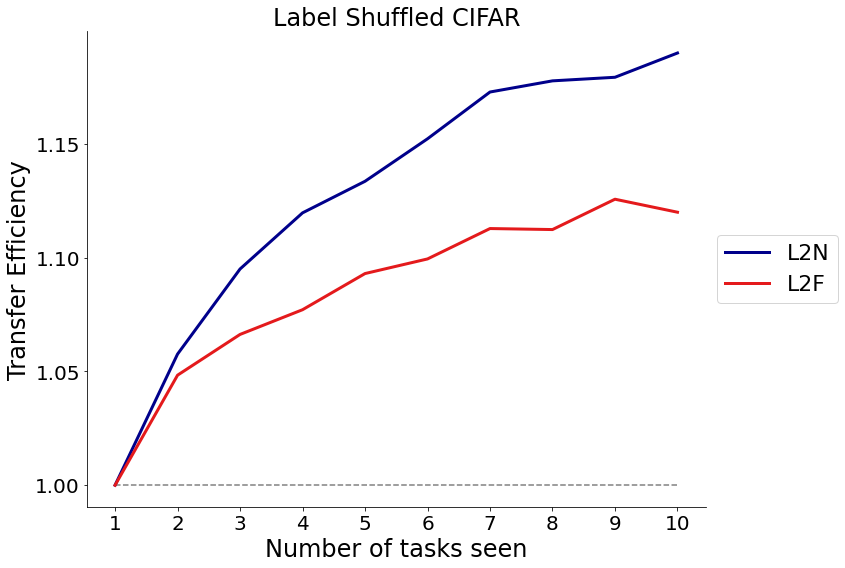

In [21]:
slots = 1
shifts = 6
alg_name = ['L2N','L2F']

if model == "uf":
    alg_name = alg_name[1]
elif model == "dnn":
    alg_name = alg_name[0]

reps = slots*shifts
btes = np.zeros((len(alg_name),10),dtype=float)

for alg_no,alg in enumerate(alg_name):
    bte_tmp = [[] for _ in range(reps)]

    count = 0   
    for slot in range(slots):
        for shift in range(shifts):
            err = []

            for ii in range(10):
                err.extend(
                1 - np.array(
                    df[df['task']==ii+1]['task_1_accuracy']
                )
                )
            bte = get_bte(err)
        
            bte_tmp[count].extend(bte)
            count+=1
    
    # Calculate the mean backwards transfer efficiency
    btes[alg_no] = np.mean(bte_tmp, axis = 0)
    
clr = ["#00008B", "#e41a1c", "#a65628", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#CCCC00"]
c = sns.color_palette(clr, n_colors=len(clr))
fig, ax = plt.subplots(1,1, figsize=(10,8))

# Plot the results
for alg_no,alg in enumerate(alg_name):
    if alg_no<2:
        ax.plot(np.arange(1,11),btes[alg_no], c=c[alg_no], label=alg_name[alg_no], linewidth=3)
    else:
        ax.plot(np.arange(1,11),btes[alg_no], c=c[alg_no], label=alg_name[alg_no])

ax.set_yticks([.9,.95, 1, 1.05,1.1,1.15,1.2])
ax.set_xticks(np.arange(1,11))
ax.tick_params(labelsize=20)
ax.set_xlabel('Number of tasks seen', fontsize=24)
ax.set_ylabel('Transfer Efficiency', fontsize=24)
ax.set_title("Label Shuffled CIFAR", fontsize = 24)
ax.hlines(1,1,10, colors='grey', linestyles='dashed',linewidth=1.5)
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)
plt.tight_layout()
ax.legend(loc='center left', bbox_to_anchor=(1,0.5), fontsize=22)
plt.savefig('./result/figs/label_shufffle.pdf', dpi=500)